In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/University/machine_learning/old_ml/exercise

Mounted at /content/gdrive
/content/gdrive/MyDrive/University/machine_learning/old_ml/exercise


In [2]:
!ls

0_ml_exercise_preprocess.ipynb	1_ml_exercise_classical.ipynb  2_ml_exercise_neural.ipynb  data


In [ ]:
#imports for data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#imports for data set balancing
from imblearn.over_sampling import SMOTE

#imports for model training and evaluation
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

np.random.seed(42)

In [ ]:
depress_kbest = pd.read_csv("data/depress_kbest.csv")
depress_kbest.head()

,DEPRI,INFER,ANXI,POSSAT,CHEAT,ABUSED,CONFLICT,SUICIDE,THREAT,LOST,FINSTR,INSOM,ENVSAT,DEBT,DEPRESSED
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [ ]:
depress_rfe = pd.read_csv("data/depress_rfe.csv")
depress_rfe.head()

,DEPRI,INFER,ANXI,POSSAT,CHEAT,CONFLICT,LOST,FINSTR,ENVSAT,EDU,WRKPRE,TSSN,AVGSLP,PHYEX,DEPRESSED
0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,3.0,2.0,1.0
2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,3.0,1.0,2.0,0.0
3,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,2.0,1.0,1.0
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,1.0


In [ ]:
X_kbest = depress_kbest.drop("DEPRESSED", axis=1)
y_kbest = depress_kbest["DEPRESSED"]

X_rfe = depress_rfe.drop("DEPRESSED", axis=1)
y_rfe = depress_rfe["DEPRESSED"]

##1 Select K Best data set

###1.1 Data set balancing

In [ ]:
X_train_kbest, X_test_kbest, y_train_kbest, y_test_kbest = train_test_split(X_kbest, y_kbest, test_size=0.2,
                                                                            random_state=42, stratify=y_kbest)


X_train_kbest.shape, X_test_kbest.shape, y_train_kbest.shape, y_test_kbest.shape

((483, 14), (121, 14), (483,), (121,))

Let's check the dataset's balance.

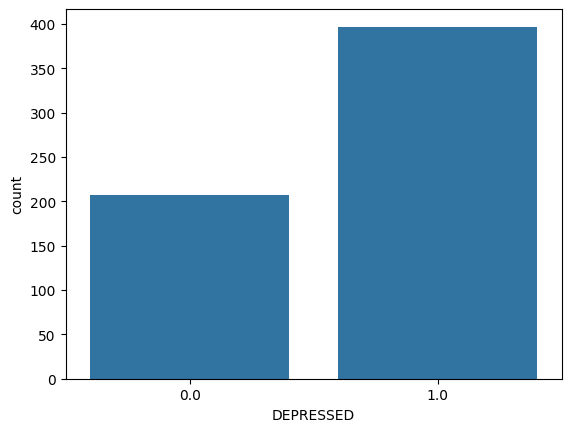

In [ ]:
sns.countplot(x="DEPRESSED", data=depress_kbest);

Using smote,  I oversampled the minority class to balance out the data set (https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

We only apply this oversampling to the training data, to avoid data leakage.

In [ ]:
sm = SMOTE(random_state=42)
X_train_kbest_res, y_train_kbest_res = sm.fit_resample(X_train_kbest, y_train_kbest)

In [ ]:
np.bincount(y_train_kbest_res)

array([317, 317])

In [ ]:
X_train_kbest_res.shape, y_train_kbest_res.shape

((634, 14), (634,))

In [ ]:
#y_train_kbest_res = y_train_kbest_res.to_numpy()
#y_test = y_test.to_numpy()

###1.2 Training

The dataset doesn't contain any missing values, so there is no use to implement the KNN Imputer. Furthermore, as Adaptive Boosting belongs to the family of Decision Tree-based algorithms, they never use multiple features at the same time, making feature scaling not necessary, unlike in other Machine Learning algorithms (Géron, p.725).

In [ ]:
#SAMME.R algorithm has been deprecated since version 1.4 and removed in 1.6 as per sklearn's documentation
#so we define it's alternative SAMME as the default

booster = AdaBoostClassifier(random_state=42, algorithm="SAMME")

In [ ]:
booster.get_params()

{'algorithm': 'SAMME',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

Set up a grid search.

In [ ]:
param_grid = {"n_estimators": [30, 50, 60, 100, 150],
              "learning_rate": [0.05, 0.1, 0.2, 0.3, 0.5, 1.0]}

In [ ]:
gs_kbest = GridSearchCV(booster,
                        param_grid,
                        cv=10,
                        scoring='f1_macro',
                        n_jobs=-1,
                        verbose=1,
                        refit=True)

We fit the data not to the original train data, but to the resized data performed by SMOTE.

In [ ]:
gs_kbest.fit(X_train_kbest_res, y_train_kbest_res)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(algorithm='SAMME', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5, 1.0],
                         'n_estimators': [30, 50, 60, 100, 150]},
             scoring='f1_macro', verbose=1)

In [ ]:
gs_kbest.best_score_

0.9134957112045955

In [ ]:
gs_kbest.best_estimator_

AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=42)

              precision    recall  f1-score   support

         0.0       0.75      0.93      0.83        41
         1.0       0.96      0.84      0.89        80

    accuracy                           0.87       121
   macro avg       0.85      0.88      0.86       121
weighted avg       0.89      0.87      0.87       121



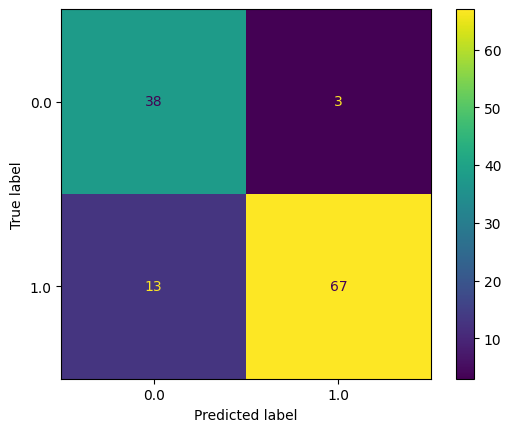

In [ ]:
predictions = gs_kbest.predict(X_test_kbest)
print(classification_report(y_test_kbest, predictions))
ConfusionMatrixDisplay.from_predictions(y_test_kbest, predictions);

###1.3 Error analysis


Let's plot the value of importance the model had given to the features.

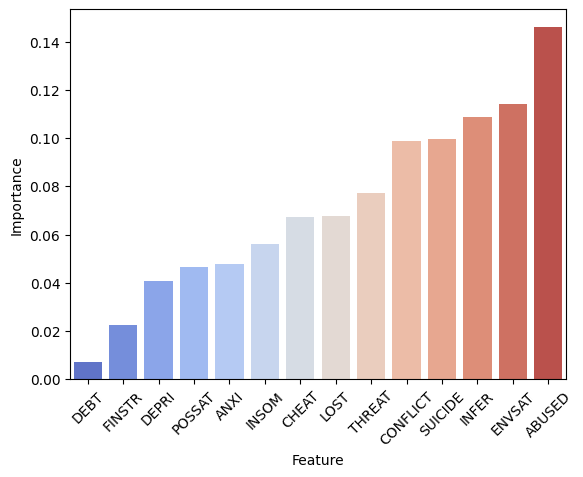

In [ ]:
feat_import = gs_kbest.best_estimator_.feature_importances_

#create data frame with feature importances
import_feat = pd.DataFrame(index=X_kbest.columns,
                           data=feat_import,
                           columns=["Importance"])
import_feat = import_feat.sort_values("Importance")

#create the plot
colours = sns.color_palette("coolwarm", len(import_feat))

sns.barplot(data=import_feat,
            x=import_feat.index,
            y="Importance",
            hue=import_feat.index,
            palette=colours,
            legend=False)

plt.xlabel("Feature")
plt.xticks(rotation=45);

We'll separate the errors the model made from the correct predictions it performed.

In [ ]:
x_error = X_test_kbest[predictions != y_test_kbest]

x_correct = X_test_kbest[predictions == y_test_kbest]

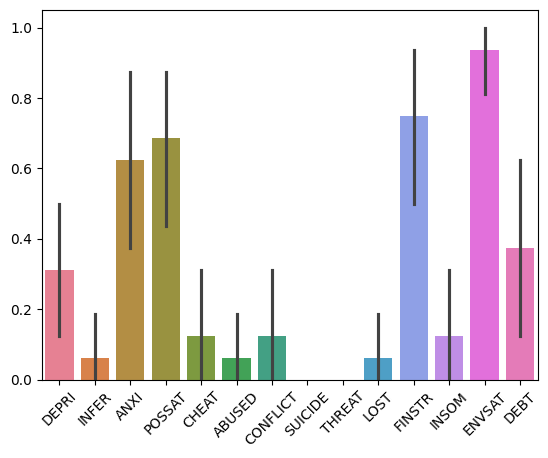

In [ ]:
sns.barplot(data=x_error)
plt.xticks(rotation=45);

The plot shows that AXNI, POSSAT, FINSTR and ENVSAT had the most weight in making incorrect predictions.

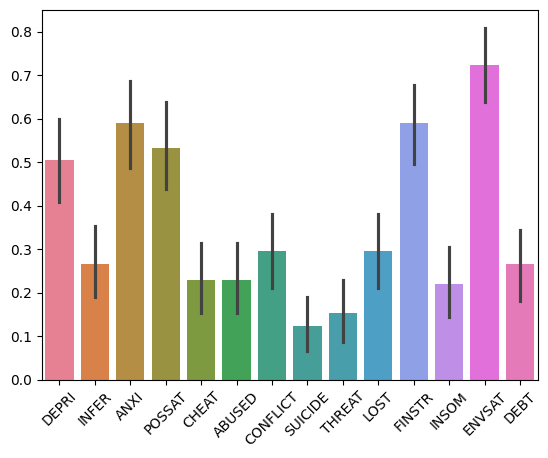

In [ ]:
sns.barplot(data=x_correct)
plt.xticks(rotation=45);

##2 RFE data set

###2.1 Data set balancing

In [ ]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe, y_rfe, test_size=0.2,
                                                                    random_state=42, stratify=y_rfe)

X_train_rfe.shape, X_test_rfe.shape, y_train_rfe.shape, y_test_rfe.shape

((483, 14), (121, 14), (483,), (121,))

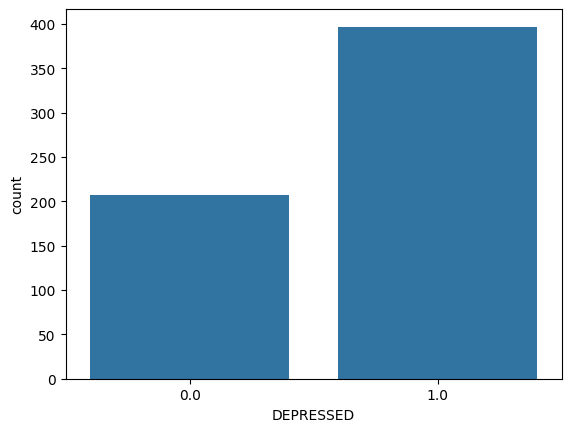

In [ ]:
sns.countplot(x="DEPRESSED", data=depress_rfe);

In [ ]:
X_train_rfe_res, y_train_rfe_res = sm.fit_resample(X_train_rfe, y_train_rfe)

In [ ]:
np.bincount(y_train_rfe_res)

array([317, 317])

In [ ]:
X_train_rfe_res.shape, y_train_rfe_res.shape

((634, 14), (634,))

###2.2 Training

In [ ]:
gs_rfe = GridSearchCV(booster,
                      param_grid,
                      cv=10,
                      scoring='f1_macro',
                      n_jobs=-1,
                      verbose=1,
                      refit=True)

gs_rfe.fit(X_train_rfe_res, y_train_rfe_res)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(algorithm='SAMME', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5, 1.0],
                         'n_estimators': [30, 50, 60, 100, 150]},
             scoring='f1_macro', verbose=1)

In [ ]:
gs_rfe.best_score_

0.9071753120888694

In [ ]:
gs_rfe.best_estimator_

AdaBoostClassifier(algorithm='SAMME', n_estimators=60, random_state=42)

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.86        41
         1.0       0.96      0.89      0.92        80

    accuracy                           0.90       121
   macro avg       0.88      0.91      0.89       121
weighted avg       0.91      0.90      0.90       121



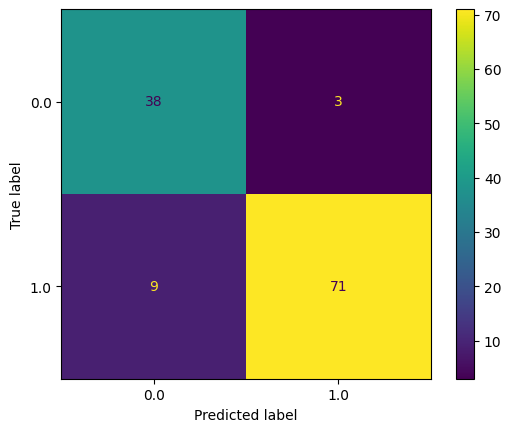

In [ ]:
predictions = gs_rfe.predict(X_test_rfe)
print(classification_report(y_test_rfe, predictions))
ConfusionMatrixDisplay.from_predictions(y_test_rfe, predictions);

###2.3 Error analysis

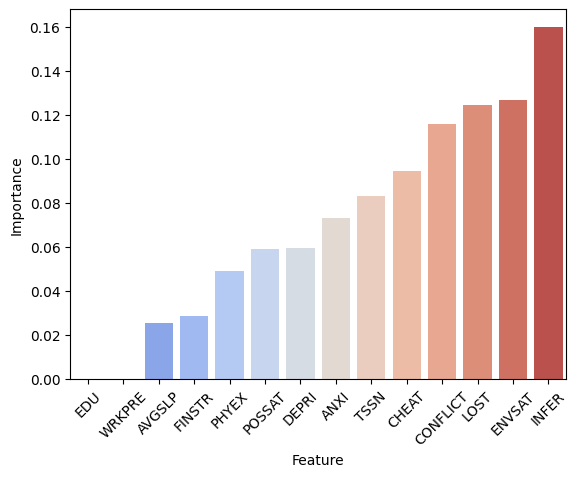

In [ ]:
feat_import = gs_rfe.best_estimator_.feature_importances_

import_feat = pd.DataFrame(index=X_rfe.columns,
                           data=feat_import,
                           columns=["Importance"])
import_feat = import_feat.sort_values("Importance")

colours = sns.color_palette("coolwarm", len(import_feat))

sns.barplot(data=import_feat,
            x=import_feat.index,
            y="Importance",
            hue=import_feat.index,
            palette=colours,
            legend=False)

plt.xlabel("Feature")
plt.xticks(rotation=45);

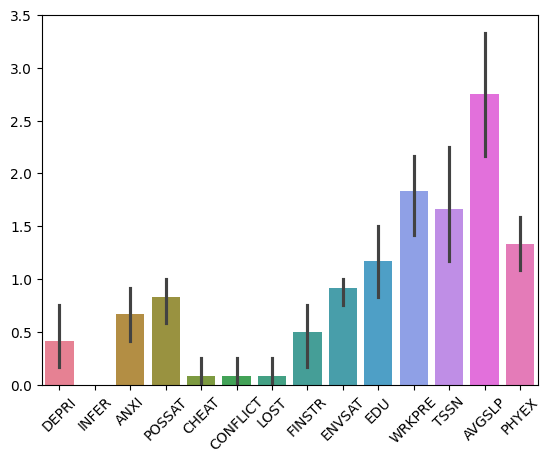

In [ ]:
x_error = X_test_rfe[predictions != y_test_rfe]

x_correct = X_test_rfe[predictions == y_test_rfe]

sns.barplot(data=x_error)
plt.xticks(rotation=45);

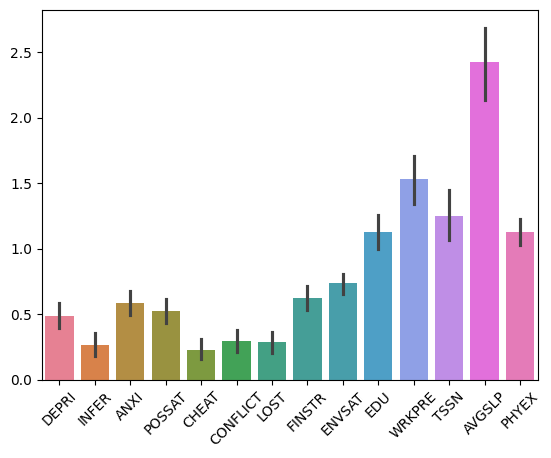

In [ ]:
sns.barplot(data=x_correct)
plt.xticks(rotation=45);

Ordinally encoded features had the most weight in making predictions. Given that implementing ordinally encoded features resulted in better model performance, it would be interesting to see what would happen if these features were one-hot encoded as well, perhaps most importantly, how it would impact recursive feature elimination.